# Random Forest Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import help_function as hf  # customized help functions
%matplotlib inline

df = pd.read_csv('data/ai4i2020.csv')

X = df.drop(columns='Machine failure')
y = df['Machine failure']

# train test split
# use stratify to enforce the proportion in the splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
pipe = hf.create_pipe(clf)
pipe.fit(X_train, y_train)

Pipeline(steps=[('proc_cols',
                 FunctionTransformer(func=<function col_name_cnvt at 0x000001D850E95700>)),
                ('prep',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8535C4370>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8535C46D0>)])),
                ('model', RandomForestClassifier())])

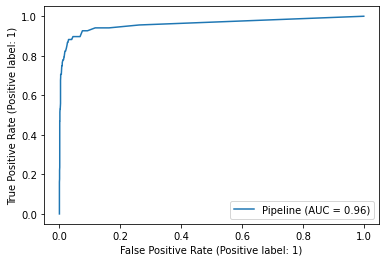

In [4]:
# Search for the best cutoff threshold
hf.RocCurveDisplay.from_estimator(pipe, X_test, y_test);

- The ROC curve looks almost perfect. It seems Random Forest can do a good job.

### Use leave-one-out evaluation

{'recall': 0.7941176470588235,
 'precision': 0.6506024096385542,
 'f1': 0.7152317880794702}

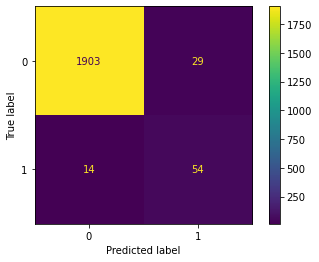

In [5]:
# try cutoff = 0.23
# use the leave-one-out evaluation
y_hats = hf.soft_to_hard(pipe, X_test, cutoff=0.23)
hf.evaluate(y_test, y_hats)

### Use cross validation to generalize the evaluation

In [6]:
# calculate the cross-validated scores, use the same cutoff
hf.k_fold(pipe, X_train, y_train, k=40, cutoff=0.23)

{'Mean Recall': 0.780357142857143,
 'Mean Precision': 0.6608080808080808,
 'Mean F1': 0.7029339941104646}

#### Try different cutoffs

In [10]:
hf.k_fold(pipe, X_train, y_train, k=40, cutoff=0.25)

{'Mean Recall': 0.7827380952380952,
 'Mean Precision': 0.6927534271284271,
 'Mean F1': 0.7260000770643186}

In [13]:
hf.k_fold(pipe, X_train, y_train, k=40, cutoff=0.26)

{'Mean Recall': 0.7720238095238096,
 'Mean Precision': 0.7076839826839827,
 'Mean F1': 0.7309335762276938}

In [12]:
# this cutoff shows the best result
hf.k_fold(pipe, X_train, y_train, k=40, cutoff=0.27)

{'Mean Recall': 0.7505952380952381,
 'Mean Precision': 0.7478219696969697,
 'Mean F1': 0.7370630921366216}

In [14]:
hf.k_fold(pipe, X_train, y_train, k=40, cutoff=0.28)

{'Mean Recall': 0.756547619047619,
 'Mean Precision': 0.7282195582195582,
 'Mean F1': 0.7331637439358027}

#### Use best cutoff with test data

{'recall': 0.7794117647058824,
 'precision': 0.7464788732394366,
 'f1': 0.762589928057554}

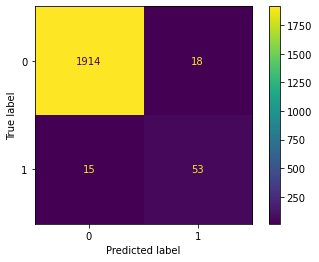

In [15]:
y_hats = hf.soft_to_hard(pipe, X_test, cutoff=0.27)
hf.evaluate(y_test, y_hats)

- f1 score is much higher now wit cutoff = 0.27.

### Hyperparameter Tuning

#### Grid search aiming for high *f1* score

In [30]:
from sklearn.model_selection import GridSearchCV
import time

param_grid = {
    'model__n_estimators': [190, 200],
    'model__class_weight': [{0:4, 1:6}, {0:39, 1:61}],
    'model__max_samples': [0.95, 0.96],
    'model__max_features': ['log2'],
}

start = time.time()

grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=40, scoring='f1', 
                    refit=True, n_jobs=8)
grid.fit(X_train, y_train)

end = time.time()
print('Time elapsed: ', end - start, 'seconds')

Time elapsed:  57.23220419883728 seconds


In [31]:
grid.best_params_

{'model__class_weight': {0: 4, 1: 6},
 'model__max_features': 'log2',
 'model__max_samples': 0.95,
 'model__n_estimators': 200}

In [32]:
# best f1 score
grid.best_score_

0.7466303141303141

#### Grid search aiming for high *recall* score

In [27]:
from sklearn.model_selection import GridSearchCV
import time

param_grid = {
    'model__n_estimators': [250, 300],
    'model__class_weight': [{0:4, 1:6}, {0:39, 1:61}, {0:38, 1:62}],
    'model__max_samples': [0.95, 0.96],
    'model__max_features': ['log2'],
}

start = time.time()

grid_recall = GridSearchCV(pipe, param_grid=param_grid, 
                           cv=40, scoring='recall', 
                           refit=True, n_jobs=8)

grid_recall.fit(X_train, y_train)

end = time.time()
print('Time elapsed: ', end - start, 'seconds')

Time elapsed:  118.17156267166138 seconds


In [28]:
grid_recall.best_params_

{'model__class_weight': {0: 39, 1: 61},
 'model__max_features': 'log2',
 'model__max_samples': 0.95,
 'model__n_estimators': 250}

In [29]:
# best recall score
grid_recall.best_score_

0.6464285714285714

### Use the best parameters for evaluation

In [36]:
# Instantiate a new model with best hyperparameters
from sklearn.ensemble import RandomForestClassifier
clf_best = RandomForestClassifier(class_weight={0: 4, 1: 6}, 
                                  max_features='log2', 
                                  max_samples=0.95, 
                                  n_estimators=210)
pipe_best = hf.create_pipe(clf_best)
pipe_best.fit(X_train, y_train)

Pipeline(steps=[('proc_cols',
                 FunctionTransformer(func=<function col_name_cnvt at 0x000001D850E95700>)),
                ('prep',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D856D4F850>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D856D4F430>)])),
                ('model',
                 RandomForestClassifier(class_weight={0: 4, 1: 6},
                                        max_features='log2', max_samples=0.95,
                                        n_estimators=210))])

#### A quick evaluation

{'recall': 0.75, 'precision': 0.68, 'f1': 0.7132867132867132}

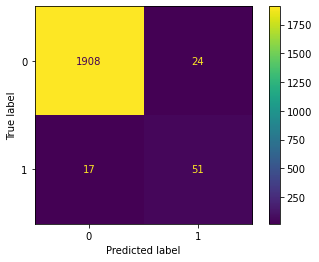

In [37]:
# try the old previous cutoff value
y_hats = hf.soft_to_hard(pipe_best, X_test, cutoff=0.27)
hf.evaluate(y_test, y_hats)

#### Search for best cutoff for this model

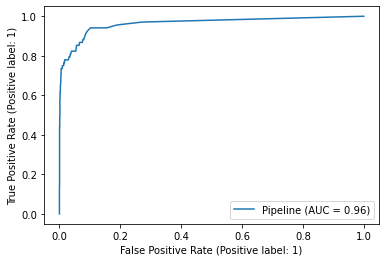

In [38]:
# Visualize the best cutoff threshold
hf.RocCurveDisplay.from_estimator(pipe_best, X_test, y_test);

In [39]:
# search for the best cutoff
import time

cutoffs = np.arange(0.20, 0.28, 0.01)
scores = []

start = time.time()

for cutoff in cutoffs:
    score = hf.k_fold(pipe_best, X_train, y_train, k=40, cutoff=cutoff)
    scores.append((cutoff, score))
    
end = time.time()
print('Elasped time: ', end - start, 'seconds')

Elasped time:  444.66040110588074 seconds


In [40]:
scores

[(0.2,
  {'Mean Recall': 0.8416666666666668,
   'Mean Precision': 0.6268012543012543,
   'Mean F1': 0.7098913668031315}),
 (0.21000000000000002,
  {'Mean Recall': 0.8309523809523809,
   'Mean Precision': 0.6561123598623599,
   'Mean F1': 0.7231294866124587}),
 (0.22000000000000003,
  {'Mean Recall': 0.8279761904761905,
   'Mean Precision': 0.6526387501387501,
   'Mean F1': 0.7211603843782637}),
 (0.23000000000000004,
  {'Mean Recall': 0.8202380952380952,
   'Mean Precision': 0.6725972638472639,
   'Mean F1': 0.7282044494892792}),
 (0.24000000000000005,
  {'Mean Recall': 0.8166666666666667,
   'Mean Precision': 0.6794200937950938,
   'Mean F1': 0.7332549330614346}),
 (0.25000000000000006,
  {'Mean Recall': 0.813095238095238,
   'Mean Precision': 0.6983585858585858,
   'Mean F1': 0.7420007157874805}),
 (0.26000000000000006,
  {'Mean Recall': 0.805952380952381,
   'Mean Precision': 0.7104473304473304,
   'Mean F1': 0.7454093075397255}),
 (0.2700000000000001,
  {'Mean Recall': 0.8017857142

- We will choose choose cutoff = 0.25 for this model since it is relatively high recall.

{'recall': 0.7647058823529411,
 'precision': 0.6419753086419753,
 'f1': 0.697986577181208}

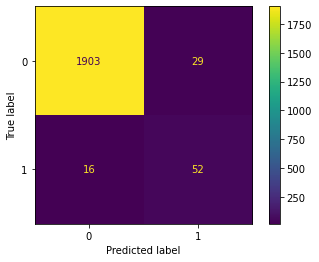

In [41]:
# try the new cutoff value
y_hats = hf.soft_to_hard(pipe_best, X_test, cutoff=0.25)
hf.evaluate(y_test, y_hats)

- Clearly there is some bias in the leave-one-out test sample.